In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Unsupervised exploration of feature representations

In [2]:
df = pd.read_csv('../datafiles/full_sample_test.csv')

white = 'White'
asian = 'Asian'
black = 'Black'

In [3]:
labels = [
    'No Finding',
    'Enlarged Cardiomediastinum',
    'Cardiomegaly',
    'Lung Opacity',
    'Lung Lesion',
    'Edema',
    'Consolidation',
    'Pneumonia',
    'Atelectasis',
    'Pneumothorax',
    'Pleural Effusion',
    'Pleural Other',
    'Fracture',
    'Support Devices']


## Embeddings

In [4]:
model = 'densenet-all'
num_features = 1024
data_dir = '../prediction/output/disease/' + model

In [5]:
embs = pd.read_csv(data_dir + '/embeddings_test.csv')
embeds = np.array(embs.iloc[:,0:num_features])
n, m = embeds.shape
print(embeds.shape)

(38240, 1024)


### PCA

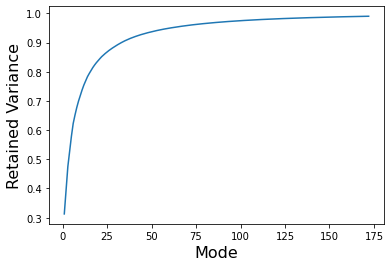

(38240, 172)


In [6]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=0.99, whiten=False)
embeds_pca = pca.fit_transform(embeds)

mu = pca.mean_
U = pca.components_.T
D = pca.singular_values_**2 / (n - 1)
exp_var = pca.explained_variance_ratio_

fig, ax = plt.subplots()
ax.plot(range(1,len(exp_var)+1),np.cumsum(exp_var))
ax.set_xlabel('Mode', fontsize=16)
ax.set_ylabel('Retained Variance', fontsize=16)
plt.show()

df['PCA Mode 1'] = embeds_pca[:,0]
df['PCA Mode 2'] = embeds_pca[:,1]

print(embeds_pca.shape)

### t-SNE (this may take a few minutes)

In [7]:
from sklearn.manifold import TSNE
embeds_tsne = TSNE(n_components=2).fit_transform(embeds_pca)

df['t-SNE Dimension 1'] = embeds_tsne[:,0]
df['t-SNE Dimension 2'] = embeds_tsne[:,1]

### Logits

In [8]:
preds = pd.read_csv(data_dir + '/predictions_test.csv')
logits = np.stack([preds['logit_0'],preds['logit_10']]).transpose()

In [9]:
df['Logit - ' + labels[0]] = logits[:,0]
df['Logit - ' + labels[10]] = logits[:,1]

### Sampling

In [10]:
n_samples = 1000

df_white = df[df['race'] == white].sample(n=n_samples)
df_asian = df[df['race'] == asian].sample(n=n_samples)
df_black = df[df['race'] == black].sample(n=n_samples)

sample_test = pd.concat([df_white, df_asian, df_black])
sample_test.to_csv(model + '-embeddings.csv')

### Plotting

In [11]:
sample_test = pd.read_csv(model + '-embeddings.csv')

# Replicate entries for having capital letters in plots
sample_test['Disease'] = sample_test['disease']
sample_test['Sex'] = sample_test['sex']
sample_test['Age'] = sample_test['age']
sample_test['Race'] = sample_test['race']

In [12]:
alpha = 0.6
style = 'o'
markersize = 40
kind = 'scatter'

method = 'logit'
xdat = 'Logit - ' + labels[0]
ydat = 'Logit - ' + labels[10]
xlim = [-8, 3]
ylim = [-8, 5]

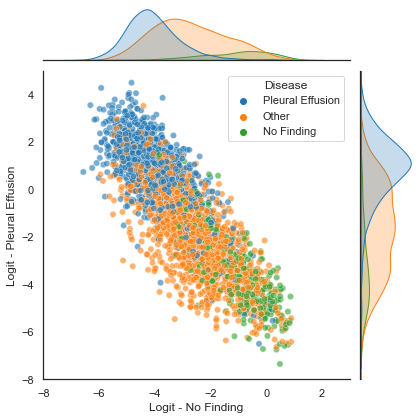

In [13]:
label = 'Disease'
sns.set_theme(style="white", palette=None)
sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, hue_order=['Pleural Effusion', 'Other', 'No Finding'], data=sample_test)
# plt.savefig(method + '-' + model + '-disease.png', bbox_inches='tight', dpi=300)

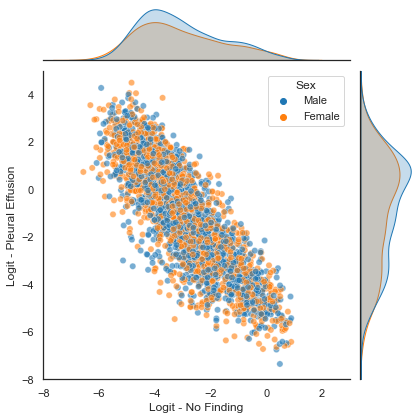

In [14]:
label = 'Sex'
sns.set_theme(style="white", palette=None)
sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, hue_order=['Male', 'Female'], data=sample_test)
# plt.savefig(method + '-' + model + '-sex.png', bbox_inches='tight', dpi=300)

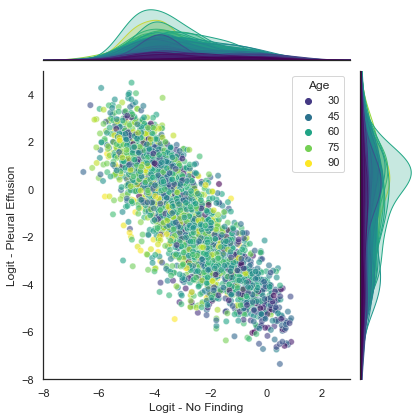

In [15]:
label = 'Age'
sns.set_theme(style="white", palette=None)
sns.jointplot(x=xdat, y=ydat, hue=label, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, palette='viridis', data=sample_test)
# plt.savefig(method + '-' + model + '-age.png', bbox_inches='tight', dpi=300)

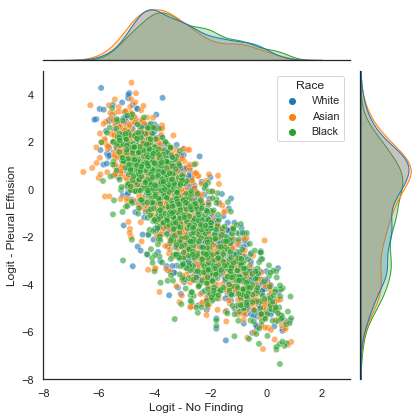

In [16]:
label = 'Race'
sns.set_theme(style="white", palette=None)
sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, xlim=xlim, ylim=ylim, marker=style, s=markersize, alpha=alpha, data=sample_test)
# plt.savefig(method + '-' + model + '-race.png', bbox_inches='tight', dpi=300)

In [17]:
method = 'tsne'
xdat = 't-SNE Dimension 1'
ydat = 't-SNE Dimension 2'
xlim = [-75, 75]
ylim = [-75, 80]

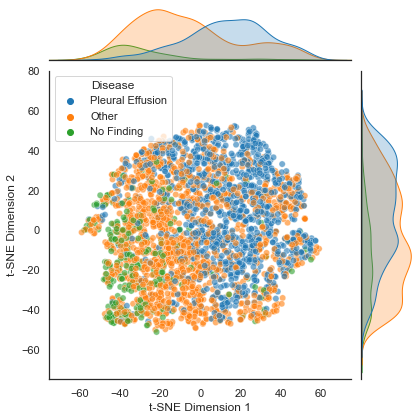

In [18]:
label = 'Disease'
sns.set_theme(style="white", palette=None)
sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, hue_order=['Pleural Effusion', 'Other', 'No Finding'], data=sample_test)
# plt.savefig(method + '-' + model + '-disease.png', bbox_inches='tight', dpi=300)

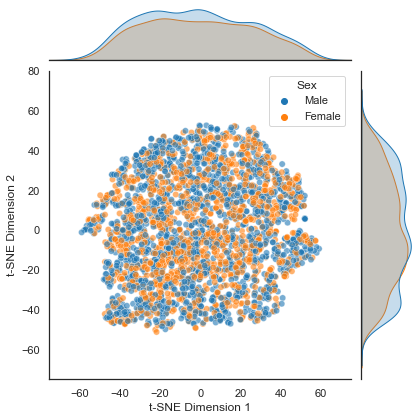

In [19]:
label = 'Sex'
sns.set_theme(style="white", palette=None)
sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, hue_order=['Male', 'Female'], data=sample_test)
# plt.savefig(method + '-' + model + '-sex.png', bbox_inches='tight', dpi=300)

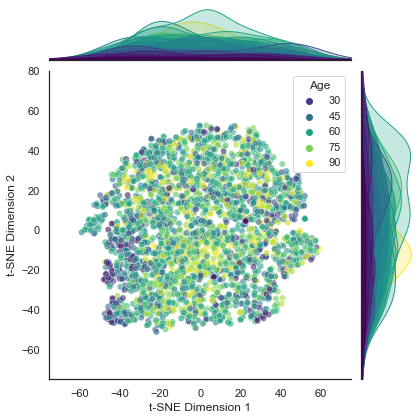

In [20]:
label = 'Age'
sns.set_theme(style="white", palette=None)
sns.jointplot(x=xdat, y=ydat, hue=label, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, palette='viridis', data=sample_test)
# plt.savefig(method + '-' + model + '-age.png', bbox_inches='tight', dpi=300)

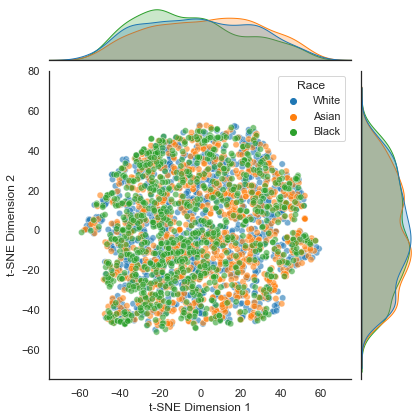

In [21]:
label = 'Race'
sns.set_theme(style="white", palette=None)
sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, xlim=xlim, ylim=ylim, marker=style, s=markersize, alpha=alpha, data=sample_test)
# plt.savefig(method + '-' + model + '-race.png', bbox_inches='tight', dpi=300)

In [22]:
method = 'pca'
xdat = 'PCA Mode 1'
ydat = 'PCA Mode 2'
xlim = [-15, 25]
ylim = [-15, 15]

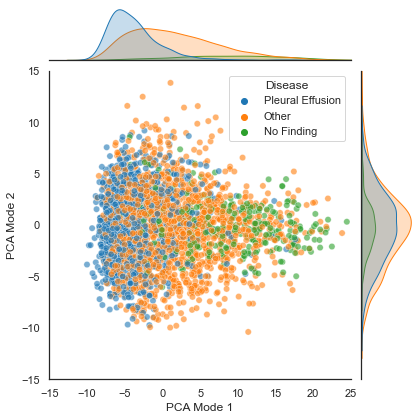

In [23]:
label = 'Disease'
sns.set_theme(style="white", palette=None)
sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, hue_order=['Pleural Effusion', 'Other', 'No Finding'], data=sample_test)
# plt.savefig(method + '-' + model + '-disease.png', bbox_inches='tight', dpi=300)

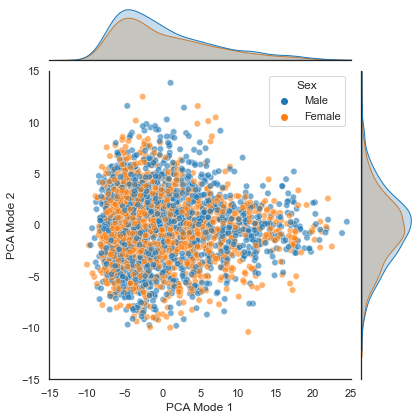

In [24]:
label = 'Sex'
sns.set_theme(style="white", palette=None)
sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, hue_order=['Male', 'Female'], data=sample_test)
# plt.savefig(method + '-' + model + '-sex.png', bbox_inches='tight', dpi=300)

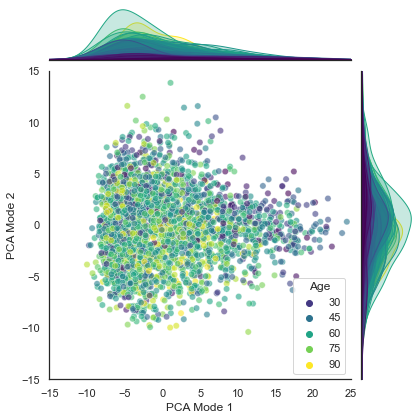

In [25]:
label = 'Age'
sns.set_theme(style="white", palette=None)
sns.jointplot(x=xdat, y=ydat, hue=label, alpha=alpha, xlim=xlim, ylim=ylim, marker=style, s=markersize, palette='viridis', data=sample_test)
# plt.savefig(method + '-' + model + '-age.png', bbox_inches='tight', dpi=300)

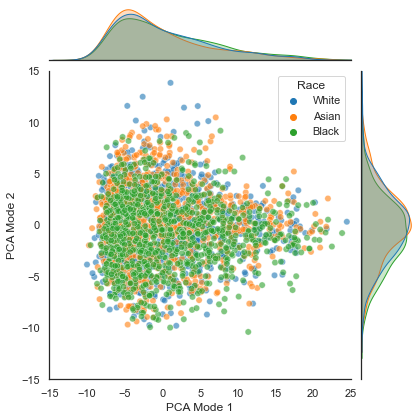

In [26]:
label = 'Race'
sns.set_theme(style="white", palette=None)
sns.jointplot(x=xdat, y=ydat, hue=label, kind=kind, xlim=xlim, ylim=ylim, marker=style, s=markersize, alpha=alpha, data=sample_test)
# plt.savefig(method + '-' + model + '-race.png', bbox_inches='tight', dpi=300)